<a href="https://colab.research.google.com/github/ArjunKanthimath/Brain-segmentation-and-tumor-detection-using-3D-UNET-on-BraTS-2020-Dataset/blob/main/Brain_Segmentation_Using_3D_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
! kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [03:08<00:00, 24.8MB/s]
100% 4.16G/4.16G [03:08<00:00, 23.6MB/s]


In [64]:
! pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 7.6 MB/s eta 0:00:00


In [65]:
import patoolib
patoolib.extract_archive("brats20-dataset-training-validation.zip")

INFO patool: Extracting brats20-dataset-training-validation.zip ...
INFO:patool:Extracting brats20-dataset-training-validation.zip ...
INFO patool: running /usr/bin/7z x -aou -o./Unpack_lnppbc8d -- brats20-dataset-training-validation.zip
INFO:patool:running /usr/bin/7z x -aou -o./Unpack_lnppbc8d -- brats20-dataset-training-validation.zip
INFO patool: ... brats20-dataset-training-validation.zip extracted to `brats20-dataset-training-validation' (multiple files in root).
INFO:patool:... brats20-dataset-training-validation.zip extracted to `brats20-dataset-training-validation' (multiple files in root).


'brats20-dataset-training-validation'

In [5]:
import os
import glob
import random
import numpy as np
import scipy.ndimage
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from tensorflow.keras import layers
#!pip install segmentation-models-3d
import segmentation_models_3D as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.layers import Input,Conv3D,MaxPooling3D,concatenate,Conv3DTranspose,BatchNormalization

# **Understandig the dataset for a single set of data**
* **Loading sample image and visualizing it.**
* **Scaling the image to [0,1].**

In [251]:
train_path = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

In [252]:
scaler = MinMaxScaler()

test_img_flair = nib.load(train_path + '/BraTS20_Training_111/BraTS20_Training_111_flair.nii').get_fdata()
print(test_img_flair.max())
test_img_flair = scaler.fit_transform(test_img_flair.reshape(-1,test_img_flair.shape[-1])).reshape(test_img_flair.shape)
print(test_img_flair.max())

1019.0
1.0


In [253]:
test_img_t1 = nib.load(train_path + '/BraTS20_Training_111/BraTS20_Training_111_t1.nii').get_fdata()
print(test_img_t1.max())
test_img_t1 = scaler.fit_transform(test_img_t1.reshape(-1,test_img_t1.shape[-1])).reshape(test_img_t1.shape)
print(test_img_t1.max())

576.0
1.0


In [254]:
test_img_t1ce = nib.load(train_path + '/BraTS20_Training_111/BraTS20_Training_111_t1ce.nii').get_fdata()
print(test_img_t1ce.max())
test_img_t1ce = scaler.fit_transform(test_img_t1ce.reshape(-1,test_img_t1ce.shape[-1])).reshape(test_img_t1ce.shape)
print(test_img_t1ce.max())

2019.0
1.0


In [255]:
test_img_t2 = nib.load(train_path + '/BraTS20_Training_111/BraTS20_Training_111_t2.nii').get_fdata()
print(test_img_t2.max())
test_img_t2 = scaler.fit_transform(test_img_t2.reshape(-1,test_img_t2.shape[-1])).reshape(test_img_t2.shape)
print(test_img_t2.max())

2067.0
1.0


In [256]:
test_mask = nib.load(train_path + '/BraTS20_Training_111/BraTS20_Training_111_seg.nii').get_fdata()
print(test_mask.max())
test_mask = test_mask.astype(np.uint8) # Converting the mask from float64 to int8

4.0


In [246]:
print(np.unique(test_mask)) # 0,1,2,4 (Need to reencode as 0,1,2,3)
test_mask[test_mask == 4] = 3 # Reassign mask value 4 to 3
print(np.unique(test_mask))

[0 1 2 4]
[0 1 2 3]


54


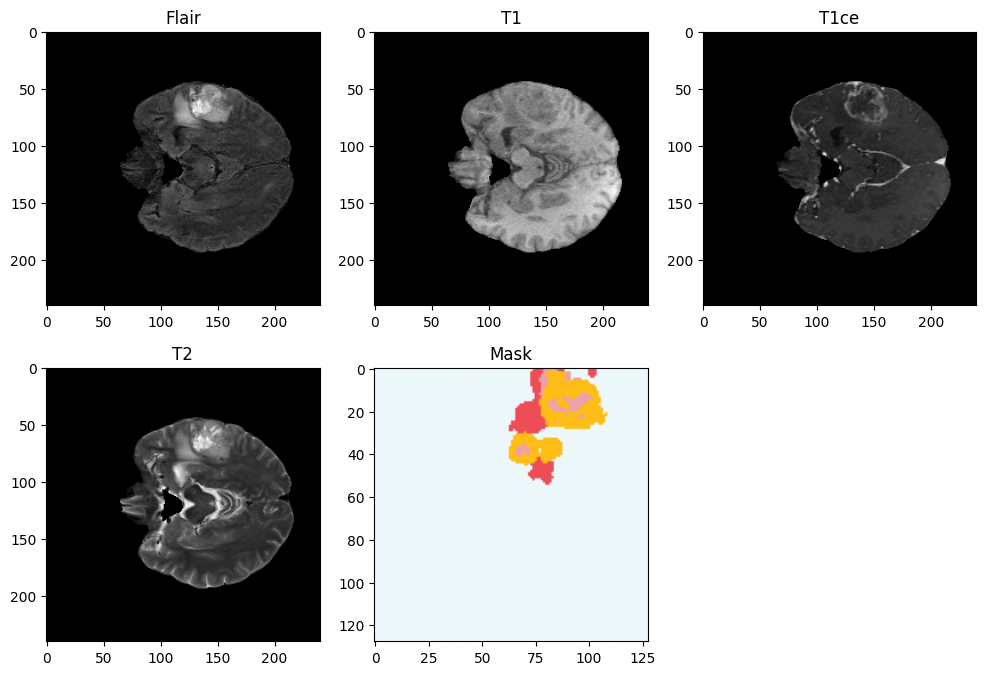

In [260]:
#n_slice = random.randint(0,test_mask.shape[2])
colors = ["#EDF8FB", "#ee4c58", "#febd17"]  # Light Blue → Red → Orange
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)
n_slice = 54
print(n_slice)
plt.figure(figsize=(12,8))

plt.subplot(231)
plt.imshow(test_img_flair[:,:,n_slice], cmap='gray')
plt.title('Flair')
plt.subplot(232)
plt.imshow(test_img_t1[:,:,n_slice], cmap='gray')
plt.title('T1')
plt.subplot(233)
plt.imshow(test_img_t1ce[:,:,n_slice], cmap='gray')
plt.title('T1ce')
plt.subplot(234)
plt.imshow(test_img_t2[:,:,n_slice], cmap='gray')
plt.title('T2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice], cmap=custom_cmap)
plt.title('Mask')
plt.savefig('test_pred.png', bbox_inches='tight')
plt.show()

# **Combining the images of a single set to form channels**

In [257]:
# Flair,T1ce,T2 have the most information
# So we combine those 3 excluding T1
combined_x = np.stack([test_img_flair,test_img_t1ce,test_img_t2],axis=3)
print(combined_x.shape)
combined_x = combined_x[56:184,56:184,13:141] # Crop to 128x128x128
print(combined_x.shape)

(240, 240, 155, 3)
(128, 128, 128, 3)


In [258]:
print(test_mask.shape)
test_mask = test_mask[56:184,56:184,13:141] # Crop to 128x128x128
print(test_mask.shape)

(240, 240, 155)
(128, 128, 128)


Text(0.5, 1.0, 'Mask')

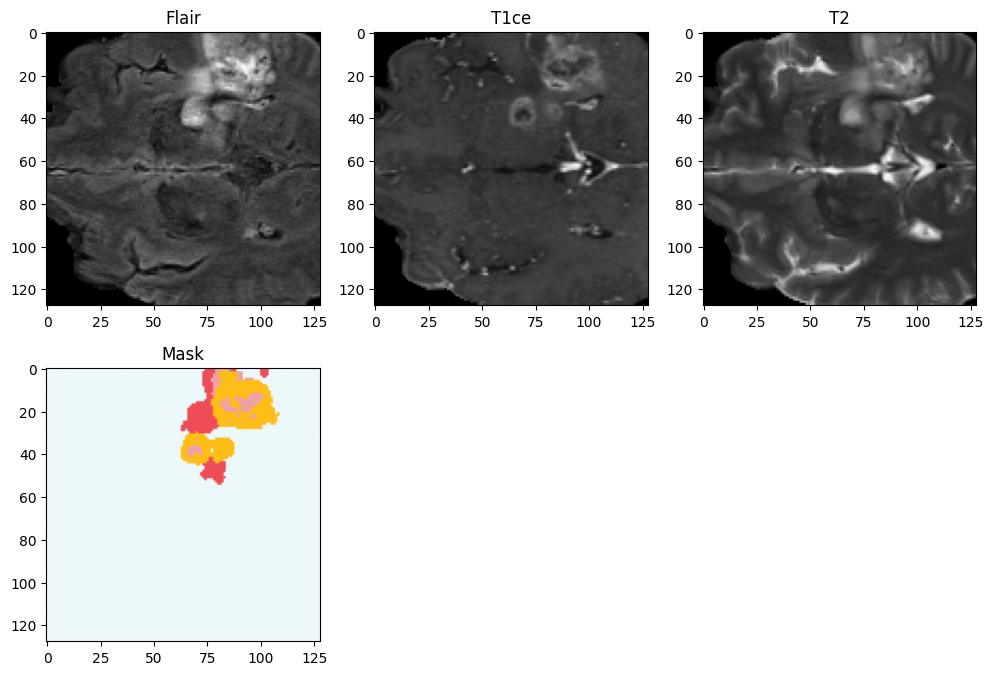

In [259]:
colors = ["#EDF8FB", "#ee4c58", "#febd17"]  # Light Blue → Red → Orange
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)
n_slice = 54
plt.figure(figsize=(12,8))

plt.subplot(231)
plt.imshow(combined_x[:,:,n_slice,0], cmap='gray')
plt.title('Flair')
plt.subplot(232)
plt.imshow(combined_x[:,:,n_slice,1], cmap='gray')
plt.title('T1ce')
plt.subplot(233)
plt.imshow(combined_x[:,:,n_slice,2], cmap='gray')
plt.title('T2')
plt.subplot(234)
plt.imshow(test_mask[:,:,n_slice], cmap=custom_cmap)
plt.title('Mask')
plt.savefig('combined_channel_img.png', bbox_inches='tight')
plt.savefig('test_pred1.png', bbox_inches='tight')
plt.title('Mask')

In [80]:
test_mask = to_categorical(test_mask,num_classes=4)
print(test_mask.shape)

(128, 128, 128, 4)


# **Extending the same procedure for the entire dataset**

In [81]:
# Folder to exclude
# excluded_folder = "BraTS20_Training_355"

# Load file paths, excluding the unwanted folder
flair_list = sorted(glob.glob('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
t1ce_list = sorted(glob.glob('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
t2_list = sorted(glob.glob('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
mask_list = sorted(glob.glob('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

In [ ]:
for img in range(len(flair_list)):
    print("Now preparing image and mask number:", img)

    img_flair = nib.load(flair_list[img]).get_fdata()
    img_flair = scaler.fit_transform(img_flair.reshape(-1, img_flair.shape[-1])).reshape(img_flair.shape)

    img_t1ce = nib.load(t1ce_list[img]).get_fdata()
    img_t1ce = scaler.fit_transform(img_t1ce.reshape(-1, img_t1ce.shape[-1])).reshape(img_t1ce.shape)

    img_t2 = nib.load(t2_list[img]).get_fdata()
    img_t2 = scaler.fit_transform(img_t2.reshape(-1, img_t2.shape[-1])).reshape(img_t2.shape)

    img_mask = nib.load(mask_list[img]).get_fdata()
    img_mask = img_mask.astype(np.uint8)
    img_mask[img_mask == 4] = 3

    # Stack images and crop to 128x128x128
    combined_img = np.stack([img_flair, img_t1ce, img_t2], axis=3)
    combined_img = combined_img[56:184, 56:184, 13:141]
    img_mask = img_mask[56:184, 56:184, 13:141]

    # Check if the mask contains tumor (at least 1% nonzero pixels)
    val, counts = np.unique(img_mask, return_counts=True)

    if (1 - (counts[0] / counts.sum())) > 0.01:
        img_mask = to_categorical(img_mask, num_classes=4)
        np.save(f'/content/drive/MyDrive/data/images/img_{img}.npy', combined_img)
        np.save(f'/content/drive/MyDrive/data/masks/img_{img}.npy', img_mask)
    else:
        print("I am useless")

In [ ]:
!pip install split-folders
import splitfolders

input_folder = '/content/drive/MyDrive/data'
output_folder = '/content/drive/MyDrive/ip_data'
splitfolders.ratio(input_folder,output=output_folder,seed=42,ratio=(.75,.25),group_prefix=None)

# **Visualizing Grey and White Matter and CSF**

Enter patient index to visualize (0-370): 110

Selected Patient Folder: BraTS20_Training_111
Using T1 File: /content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_t1.nii


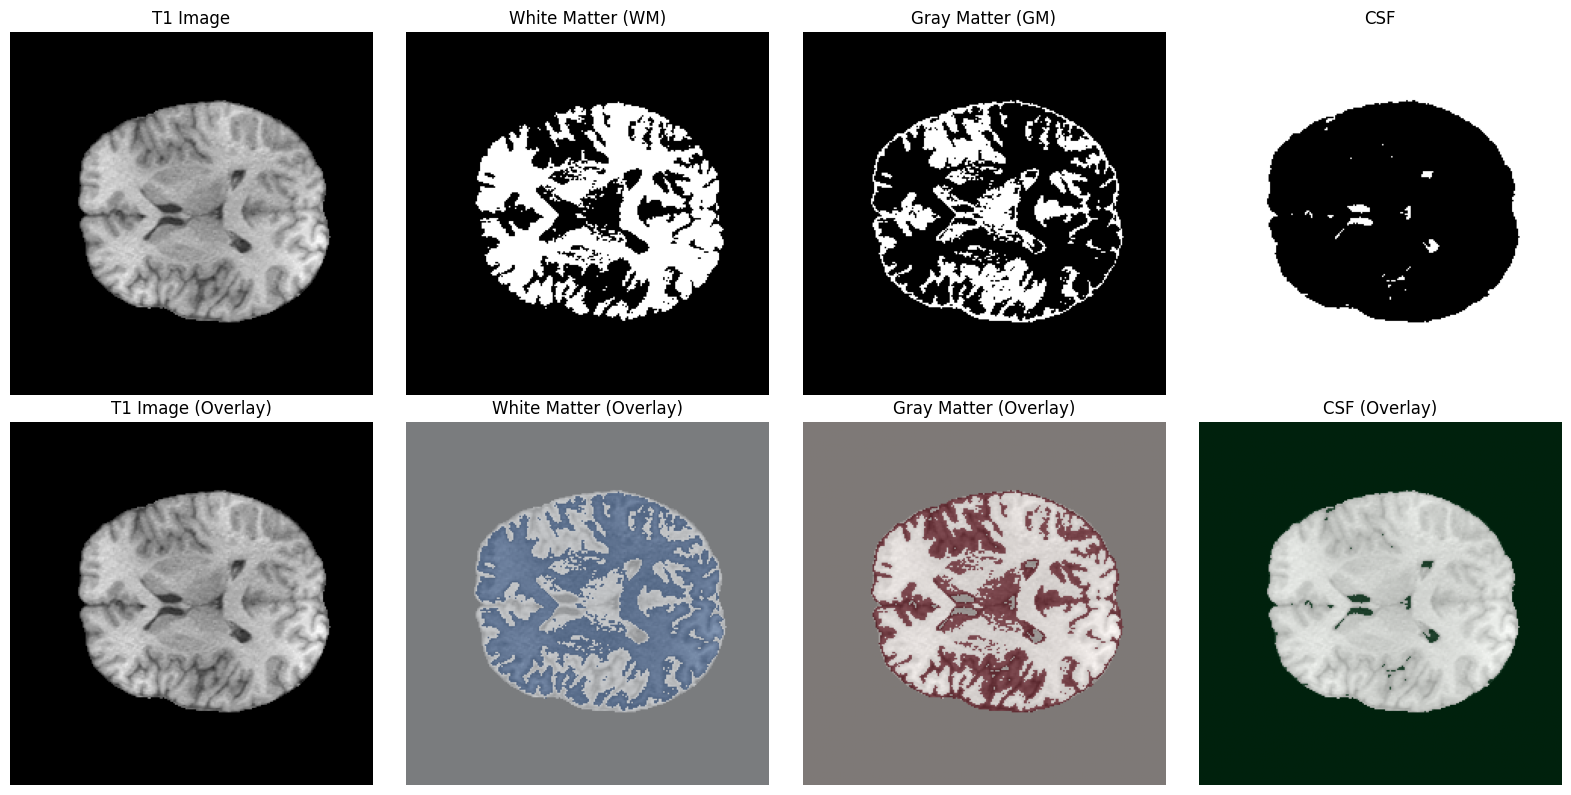


Segmentation visualization saved as BraTS20_Training_111_brain_segmentation_combined.png


In [126]:
# Define Dataset Path
base_dir = "/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# List available patient folders
patient_folders = sorted(os.listdir(base_dir))

# Ask User for Patient Selection
patient_idx = int(input(f"Enter patient index to visualize (0-{len(patient_folders)-1}): "))
selected_folder = patient_folders[patient_idx]
folder_path = os.path.join(base_dir, selected_folder)

print(f"\nSelected Patient Folder: {selected_folder}")

# Function to Find the T1 MRI File
def find_modality_file(folder_path, modality):
    for file in os.listdir(folder_path):
        if modality in file and file.endswith(".nii"):
            return os.path.join(folder_path, file)
    return None

# Locate the T1-weighted MRI scan
t1_path = find_modality_file(folder_path, "_t1.nii")

if t1_path is None:
    raise FileNotFoundError(f"T1 file not found in {folder_path}")

print("Using T1 File:", t1_path)

# Load T1 Image & Extract Middle Slice
def load_nifti(file_path):
    return nib.load(file_path).get_fdata()

t1_img = load_nifti(t1_path)

# Select the middle slice along the axial plane (Z-axis)
mid_slice = t1_img.shape[2] // 2
t1_slice = t1_img[:, :, mid_slice]

# Normalize the image for better contrast
t1_slice = (t1_slice - np.min(t1_slice)) / (np.max(t1_slice) - np.min(t1_slice))

# Segment Brain Regions Using Intensity
wm_mask = (t1_slice > 0.6).astype(np.uint8)  # White Matter (highest intensity)
gm_mask = ((t1_slice > 0.3) & (t1_slice <= 0.6)).astype(np.uint8)  # Gray Matter (mid-intensity)
csf_mask = (t1_slice <= 0.3).astype(np.uint8)  # CSF (lowest intensity)

# Visualize Segmented Regions (Separate & Overlay)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Top row: Separate segmentation maps
axes[0, 0].imshow(t1_slice, cmap="gray")
axes[0, 0].set_title("T1 Image")

axes[0, 1].imshow(wm_mask, cmap="gray")
axes[0, 1].set_title("White Matter (WM)")

axes[0, 2].imshow(gm_mask, cmap="gray")
axes[0, 2].set_title("Gray Matter (GM)")

axes[0, 3].imshow(csf_mask, cmap="gray")
axes[0, 3].set_title("CSF")

# Bottom row: Segmentation Overlaid on T1
axes[1, 0].imshow(t1_slice, cmap="gray")
axes[1, 0].set_title("T1 Image (Overlay)")

axes[1, 1].imshow(t1_slice, cmap="gray")
axes[1, 1].imshow(wm_mask, cmap="Blues", alpha=0.5)
axes[1, 1].set_title("White Matter (Overlay)")

axes[1, 2].imshow(t1_slice, cmap="gray")
axes[1, 2].imshow(gm_mask, cmap="Reds", alpha=0.5)
axes[1, 2].set_title("Gray Matter (Overlay)")

axes[1, 3].imshow(t1_slice, cmap="gray")
axes[1, 3].imshow(csf_mask, cmap="Greens", alpha=0.5)
axes[1, 3].set_title("CSF (Overlay)")

for ax in axes.flat:
    ax.axis("off")

plt.tight_layout()
#plt.savefig(f"{selected_folder}_brain_segmentation_combined.png")
plt.show()

print(f"\nSegmentation visualization saved as {selected_folder}_brain_segmentation_combined.png")

# **Custom data generator**

In [2]:
def load_img(img_dir,img_list):
    images=[]
    for i,img_name in enumerate(img_list):
        if(img_name.split('.')[1]=='npy'):
            image = np.load(img_dir+img_name)
            image = image.astype(np.float32)
            images.append(image)
    images = np.array(images)
    return(images)

In [3]:
def imageLoader(img_dir,img_list,masks_dir,masks_list,batch_size):
    l = len(img_list)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < l:
            limit = min(batch_end,l)
            x = load_img(img_dir,img_list[batch_start:limit])
            y = load_img(masks_dir,masks_list[batch_start:limit])
            y = y.astype(np.float32)
            yield (x,y)
            batch_start += batch_size
            batch_end += batch_size

In [6]:
train_img_dir = "/content/drive/MyDrive/ip_data/train/images/"
train_masks_dir = "/content/drive/MyDrive/ip_data/train/masks/"
train_img_list = os.listdir(train_img_dir)
train_masks_list = os.listdir(train_masks_dir)

val_img_dir = "/content/drive/MyDrive/ip_data/val/images/"
val_masks_dir = "/content/drive/MyDrive/ip_data/val/masks/"
val_img_list = os.listdir(val_img_dir)
val_masks_list = os.listdir(val_masks_dir)

batch_size = 2
train_img_datagen = imageLoader(train_img_dir, train_img_list, train_masks_dir, train_masks_list, batch_size)
val_img_datagen = imageLoader(val_img_dir, val_img_list, val_masks_dir, val_masks_list, batch_size)

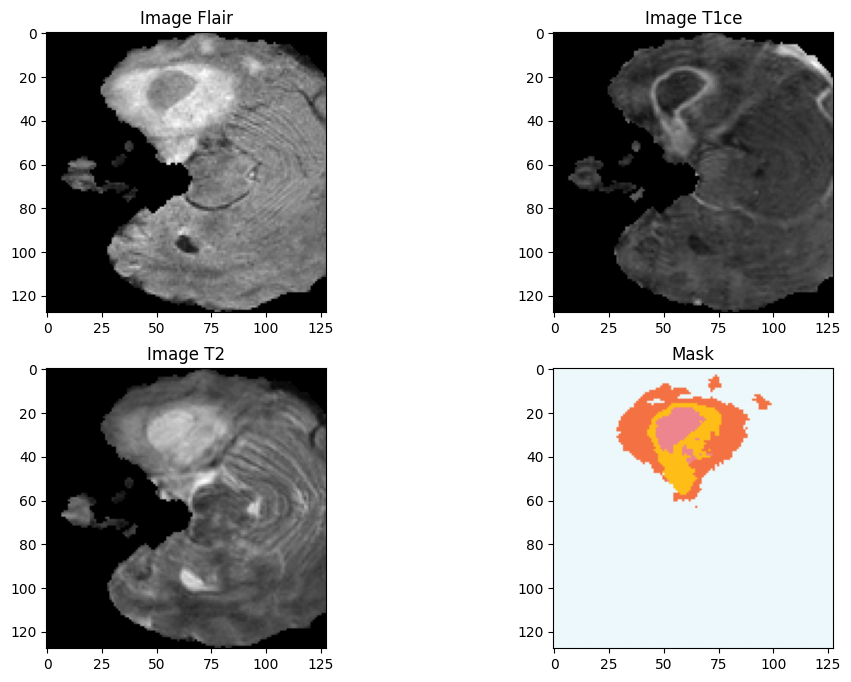

In [231]:
#img, msk = train_img_datagen.__next__()
colors = ["#EDF8FB", "#ee4c58", "#febd17"]  # Light Blue → Red → Orange
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)
num_images = len(train_img_list)
img_num = random.randint(0,num_images-1)
test_img = np.load (train_img_dir+train_img_list[img_num])
test_mask = np.load (train_masks_dir+train_masks_list[img_num])
test_mask = np.argmax(test_mask, axis=3)
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))
plt.subplot (221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image Flair')
plt.subplot (222)
plt.imshow(test_img[:,:,n_slice, 1], cmap= 'gray')
plt.title( 'Image T1ce')
plt.subplot (223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title ('Image T2')
plt.subplot ( 224)
plt.imshow(test_mask[:, :,n_slice], cmap=custom_cmap)
plt.title ('Mask')
plt.savefig('combined_channel.png', bbox_inches='tight')
plt.show()

# **Building the 3D UNET Model**

In [9]:
#!pip install segmentation-models-3d
#import segmentation_models_3D as sm
wt0,wt1,wt2,wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm. losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm. losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [5]:
kernel_initializer =  'he_uniform'

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model

In [8]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [ ]:
# from simple_3d_unet import simple_unet_model
model = simple_unet_model(IMG_HEIGHT=128,IMG_WIDTH=128,IMG_DEPTH=128,IMG_CHANNELS=3,num_classes=4)
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
#print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          1,312 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │          6,928 │ dropout[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 16) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 32) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 32) │         27,680 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 32) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32, 64) │              0 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32, 64) │        110,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16, 64) │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 16,     │              0 │ conv3d_6[0][0]         │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [ ]:
history=model.fit(train_img_datagen,
                  steps_per_epoch=steps_per_epoch,
                  epochs=100,
                  verbose=1,
                  validation_data=val_img_datagen,
                  validation_steps=val_steps_per_epoch)

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 846s 6s/step - accuracy: 0.7253 - iou_score: 0.1314 - loss: 0.9786 - val_accuracy: 0.9503 - val_iou_score: 0.2224 - val_loss: 0.9383
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9560 - iou_score: 0.2354 - loss: 0.9309 - val_accuracy: 0.9430 - val_iou_score: 0.2401 - val_loss: 0.9239
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9551 - iou_score: 0.2439 - loss: 0.9197 - val_accuracy: 0.9444 - val_iou_score: 0.2945 - val_loss: 0.9160
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9570 - iou_score: 0.3014 - loss: 0.9110 - val_accuracy: 0.9525 - val_iou_score: 0.3519 - val_loss: 0.9018
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9594 - iou_score: 0.3699 - loss: 0.9002 - val_accuracy: 0.9513 - val_iou_score: 0.4139 - val_loss: 0.8907
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9593 - iou_score: 0.4087 - loss: 0.8897 - val_accuracy: 0.9569

In [ ]:
model.save('brats_3d.hdf5')

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Find the epoch with the best validation loss
best_epoch = np.argmin(history.history['val_loss']) + 1  # +1 because epochs are 1-indexed
best_val_loss = history.history['val_loss'][best_epoch - 1]
best_val_accuracy = history.history['val_accuracy'][best_epoch - 1]

print(f"Best epoch: {best_epoch}")
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation accuracy: {best_val_accuracy}")

# Save the best model
best_model_path = '/content/drive/MyDrive/best_model.h5'
model.save(best_model_path)

print(f"Best model saved to {best_model_path}")

Best epoch: 85
Best validation loss: 0.8155136108398438
Best validation accuracy: 0.9810660481452942
Best model saved to /content/drive/MyDrive/best_model.h5


# **Visualizing the model performance**

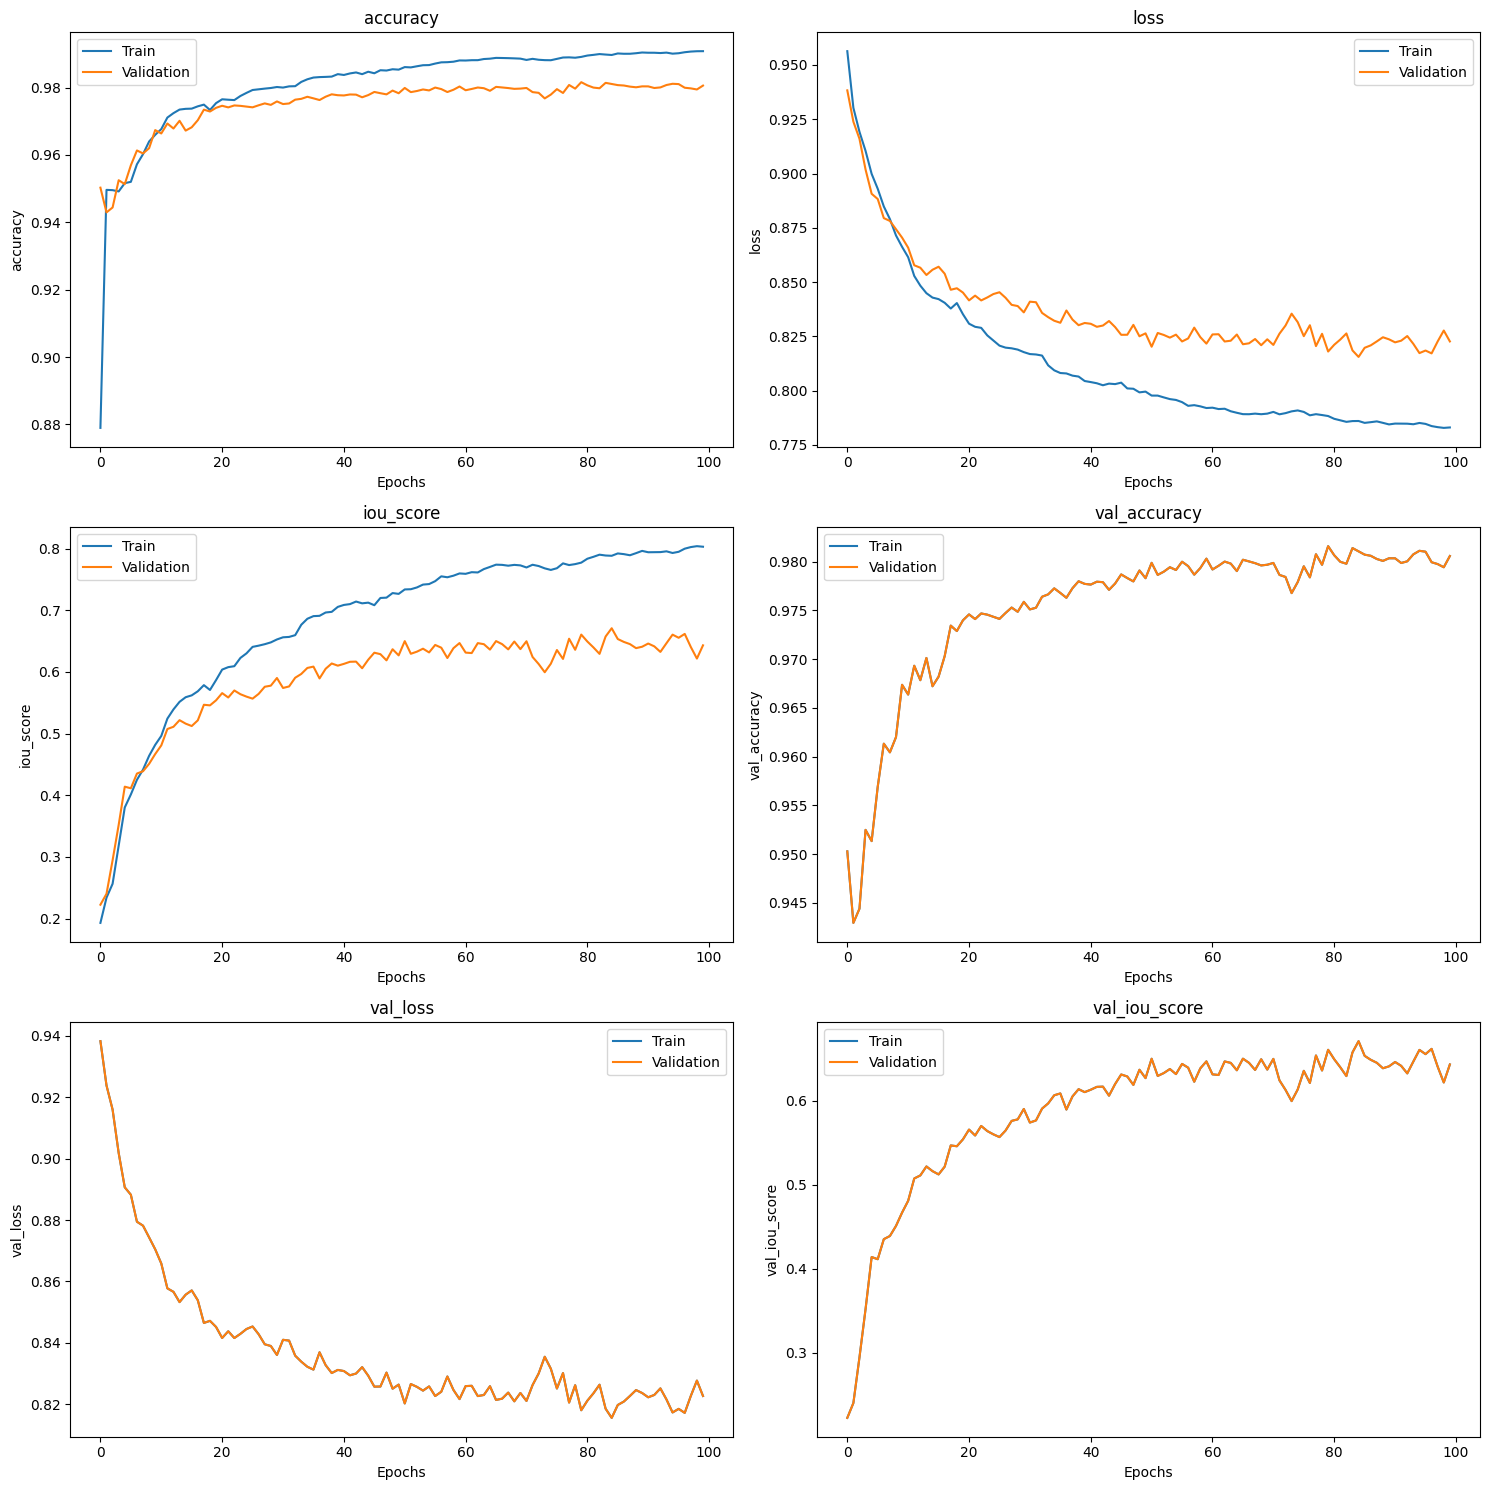

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit

# Define the metrics you want to plot
metrics = ['accuracy', 'loss', 'iou_score', 'val_accuracy', 'val_loss', 'val_iou_score']

# Determine the number of rows and columns for the grid
num_metrics = len(metrics)
num_columns = 2
num_rows = num_metrics // num_columns + (num_metrics % num_columns > 0)

# Create subplots in a grid format
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric], label='Train')
    if metric.startswith('val_'):
        val_metric = metric
        train_metric = metric[4:]
    else:
        val_metric = 'val_' + metric
        train_metric = metric
    if val_metric in history.history:
        ax.plot(history.history[val_metric], label='Validation')
    ax.set_title(metric)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('training_validation_metrics_grid.png', bbox_inches='tight')
plt.show()

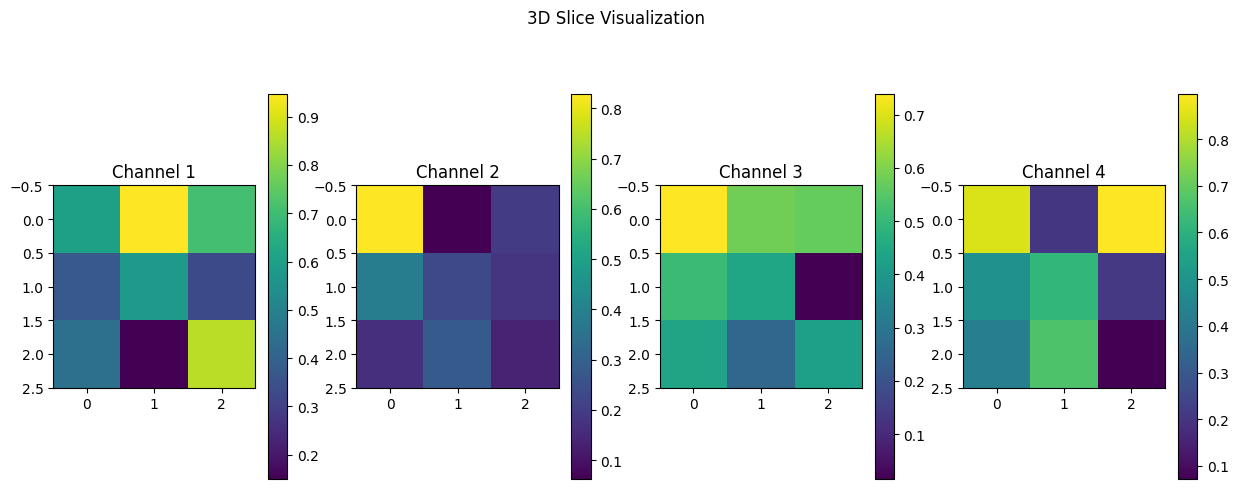

In [23]:
import plotly.express as px

# Assuming predictions is a 5D array (samples, height, width, depth, channels)
predictions = np.random.rand(2, 3, 3, 3, 4)  # Example shape

# Choose a slice to visualize, e.g., middle slice along the depth axis
slice_index = 1  # Middle index for depth

# Select the slice for each sample and channel
slices = predictions[:, slice_index, :, :, :]  # Shape: (samples, height, width, channels)

# Visualize the first sample and each channel
fig, axes = plt.subplots(1, slices.shape[3], figsize=(15, 5))
for i in range(slices.shape[3]):
    im = axes[i].imshow(slices[0, :, :, i], cmap='viridis')
    fig.colorbar(im, ax=axes[i])
    axes[i].set_title(f'Channel {i+1}')
plt.suptitle('3D Slice Visualization', y=1.05)
plt.savefig('heatmap.png', bbox_inches='tight')
plt.show()

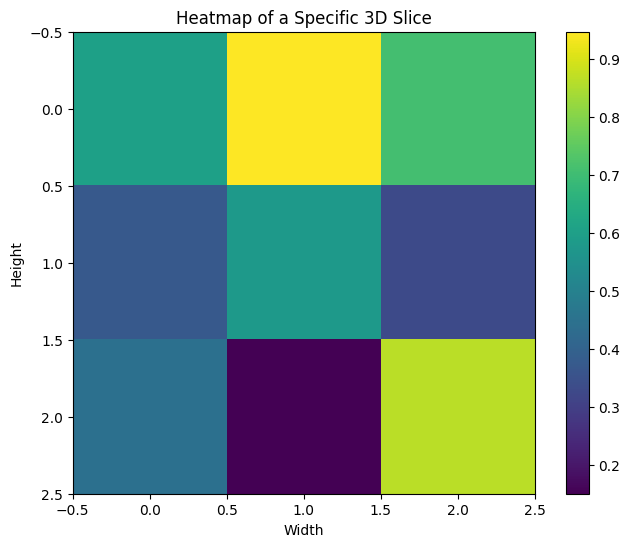

In [24]:
# Visualize a specific slice as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(slices[0, :, :, 0], cmap='viridis')
plt.colorbar()
plt.title('Heatmap of a Specific 3D Slice')
plt.xlabel('Width')
plt.ylabel('Height')
plt.savefig('heatmap_specific_slice.png', bbox_inches='tight')
plt.show()

In [10]:
#!pip install --upgrade keras tensorflow segmentation-models-3d
import numpy as np
from tensorflow.keras.models import load_model
import segmentation_models_3D as sm
from tensorflow import keras

# Assuming you have defined these variables earlier
# wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)
# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
# LR = 0.0001
# optim = keras.optimizers.Adam(LR)

#load model
my_model = load_model('/content/drive/MyDrive/brats_3d.hdf5', compile=False)

# Recompile the model with the desired optimizer, loss, and metrics
wt0,wt1,wt2,wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm. losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm. losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
LR = 0.0001
optim = keras.optimizers.Adam(LR)
my_model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

# Now you can continue training
history2 = my_model.fit(train_img_datagen,
                        steps_per_epoch=steps_per_epoch,
                        epochs=1,
                        verbose=1,
                        validation_data=val_img_datagen,
                        validation_steps=val_steps_per_epoch)

129/129 ━━━━━━━━━━━━━━━━━━━━ 851s 6s/step - accuracy: 0.9913 - iou_score: 0.7962 - loss: 0.7836 - val_accuracy: 0.9799 - val_iou_score: 0.6309 - val_loss: 0.8264


In [12]:
import pickle
with open('/content/drive/MyDrive/training_history2.pkl', 'wb') as file:
    pickle.dump(history2.history, file)

# Save the updated model
my_model.save('/content/drive/MyDrive/updated_brats_3d.hdf5')

# **Calculating the Mean IoU**

In [ ]:
from keras.metrics import MeanIoU

batch_size_size = 8
test_img_datagen = imageLoader(val_img_dir, val_img_list, val_masks_dir, val_masks_list, batch_size)
test_image_batch, test_mask_batch = test_img_datagen.__next__()
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model. predict (test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU (num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU = ", (IOU_keras.result().numpy())*100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Mean IoU =  71.60345315933228


# **Model has a Mean IoU of 71.6**

# **Visualizing test predictions**


In [235]:
img_num = 82
test_img = np.load("/content/drive/MyDrive/ip_data/val/images/img_"+str(img_num)+".npy")
test_mask = np.load ("/content/drive/MyDrive/ip_data/val/masks/img_"+str(img_num)+".npy")
test_mask_argmax = np.argmax(test_mask, axis=3)
test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0,:, :,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


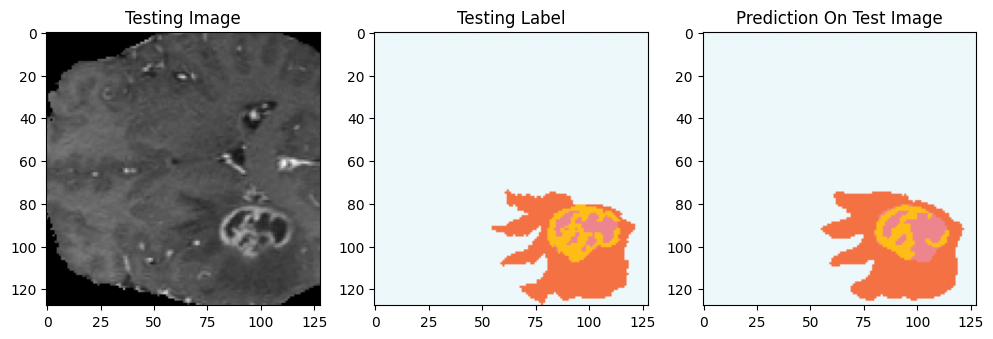

In [236]:
#n_sLice=random.randint(0, test_prediction_argmax.shape[2])
colors = ["#EDF8FB", "#ee4c58", "#febd17"]  #8856A7
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot (232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice], cmap=custom_cmap)
plt.subplot(233)
plt.title('Prediction On Test Image')
plt.imshow(test_prediction_argmax[:,:, n_slice], cmap=custom_cmap)
plt.savefig('sample_test_pred.png', bbox_inches='tight')
plt.show()

In [237]:
img_num = 111
test_img = np.load("/content/drive/MyDrive/ip_data/val/images/img_"+str(img_num)+".npy")
test_mask = np.load ("/content/drive/MyDrive/ip_data/val/masks/img_"+str(img_num)+".npy")
test_mask_argmax = np.argmax(test_mask, axis=3)
test_img_input = np. expand_dims (test_img, axis=0)
test_prediction = my_model. predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0,:, :,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


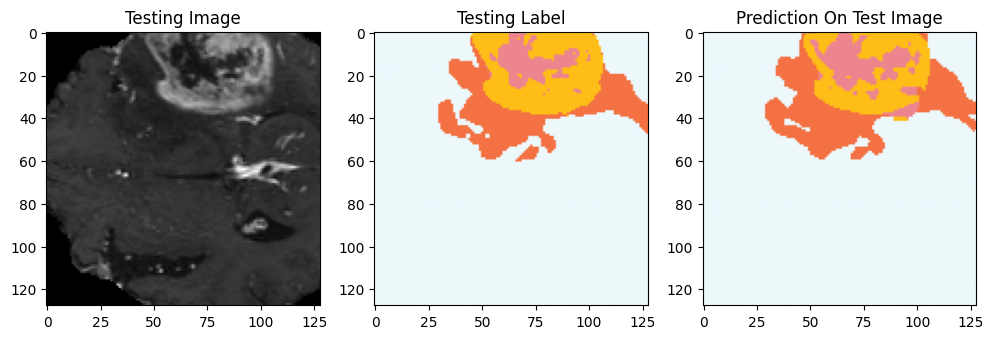

In [238]:
#n_sLice=random.randint(0, test_prediction_argmax.shape[2])
colors = ["#EDF8FB", "#ee4c58", "#febd17"]  #8856A7
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot (232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice], cmap=custom_cmap)
plt.subplot(233)
plt.title('Prediction On Test Image')
plt.imshow(test_prediction_argmax[:,:, n_slice], cmap=custom_cmap)
plt.savefig('sample_test_pred1.png', bbox_inches='tight')
plt.show()

Available test images: 0 to 85
Enter the index of the test image to visualize: 85
Image depth range: 0 to 127
Enter the slice number to visualize: 54
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


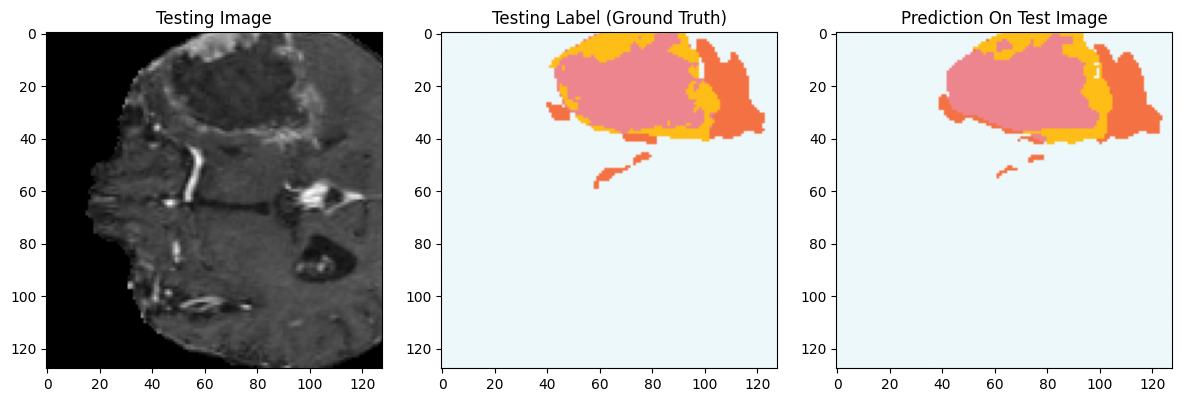


Prediction visualization displayed for Image 99, Slice 54.


In [186]:
from matplotlib.colors import LinearSegmentedColormap

#colors = ["#ADD8E6", "#FF8C00", "#008000"]  # Light Blue → Dark Orange → Green
#colors = ["#EDF8FB", "#CC607D", "#0066b2"]
colors = ["#EDF8FB", "#ee4c58", "#febd17"]  #8856A7
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

# Define Dataset Paths
image_dir = "/content/drive/MyDrive/ip_data/val/images/"
mask_dir = "/content/drive/MyDrive/ip_data/val/masks/"

image_files = sorted(os.listdir(image_dir))

# Ask User for Image Selection
print(f"Available test images: 0 to {len(image_files)-1}")
img_idx = int(input("Enter the index of the test image to visualize: "))
selected_img_file = image_files[img_idx]

# Extract image number from filename
img_num = selected_img_file.split('_')[-1].split('.')[0]  # Extracts the numeric part

# Load Selected Image & Mask
test_img = np.load(os.path.join(image_dir, f"img_{img_num}.npy"))
test_mask = np.load(os.path.join(mask_dir, f"img_{img_num}.npy"))
test_mask_argmax = np.argmax(test_mask, axis=3)

# Ask User for Slice Selection
print(f"Image depth range: 0 to {test_img.shape[2]-1}")
n_slice = int(input("Enter the slice number to visualize: "))

# Expand dimensions for prediction
test_img_input = np.expand_dims(test_img, axis=0)

# Load Model & Predict
my_model = tf.keras.models.load_model("/content/drive/MyDrive/brats_3d.hdf5", compile=False)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0, :, :, :]

# Visualize Prediction with Updated Background Colors
plt.figure(figsize=(12, 8))

# Original Image (FLAIR Channel)
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')

# Ground Truth Mask - Orange Tint Background
plt.subplot(232)
plt.title('Testing Label (Ground Truth)')
plt.imshow(test_mask_argmax[:, :, n_slice], cmap=custom_cmap)

# Model Prediction - Yellow Tint Background
plt.subplot(233)
plt.title('Prediction On Test Image')
plt.imshow(test_prediction_argmax[:, :, n_slice], cmap=custom_cmap)

plt.tight_layout()
plt.savefig(f'sample_test_pred_{img_num}_slice{n_slice}.png', bbox_inches='tight')
plt.show()

print(f"\nPrediction visualization displayed for Image {img_num}, Slice {n_slice}.")